# Obtained Metrics

We evaluate each model using the following metrics:
*   **Accuracy**: Overall correctness.
*   **Precision**: Accuracy of positive predictions (Attack).
*   **Recall**: Ability to detect actual attacks.
*   **F1-Score**: Harmonic mean of Precision and Recall.
*   **ROC-AUC**: Area Under the Receiver Operating Characteristic Curve.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import os
import glob

# Load processed test data
test_df = pd.read_csv('../data/processed/test_processed.csv')

target_col = 'Attack_type'
X_test = test_df.drop(target_col, axis=1)
y_test = test_df[target_col]

# Load models
model_paths = glob.glob('../results/models/*_best.pkl')
models = {}
for path in model_paths:
    model_name = os.path.basename(path).replace('_best.pkl', '')
    models[model_name] = joblib.load(path)

print(f"Loaded {len(models)} models: {list(models.keys())}")

Loaded 6 models: ['DecisionTree', 'KNN', 'LogisticRegression', 'NaiveBayes', 'RandomForest', 'SVM']


In [9]:
# Calculate metrics
results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    # Try to get probabilities for ROC-AUC, if not available (e.g. SVM without probability=True), use predictions
    try:
        y_proba = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    except:
        # For models that don't support predict_proba or fail, we might skip ROC-AUC or use a dummy value
        # Or if it's binary, we might need a different approach. But for multi-class 'ovr' needs proba matrix.
        roc_auc = "N/A" 
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted'),
        'ROC-AUC': roc_auc
    })

results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
os.makedirs('../results/tables', exist_ok=True)
results_df.to_csv('../results/tables/model_performance.csv', index=False)
print("Model Performance Metrics:")
display(results_df)

Model Performance Metrics:


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
4,RandomForest,0.998974,0.998965,0.998974,0.998964,0.98223
0,DecisionTree,0.998632,0.998672,0.998632,0.998633,0.980463
1,KNN,0.997392,0.997388,0.997392,0.997383,0.972535
5,SVM,0.993802,0.993969,0.993802,0.993730,N/A
2,LogisticRegression,0.993160,0.993195,0.993160,0.993117,0.985928
3,NaiveBayes,0.951567,0.967276,0.951567,0.950464,0.971866


# Confusion Matrix

The confusion matrix helps us understand the types of errors (False Positives vs. False Negatives) made by each model.

Confusion Matrix saved to ../results/figures/confusion_matrix.png


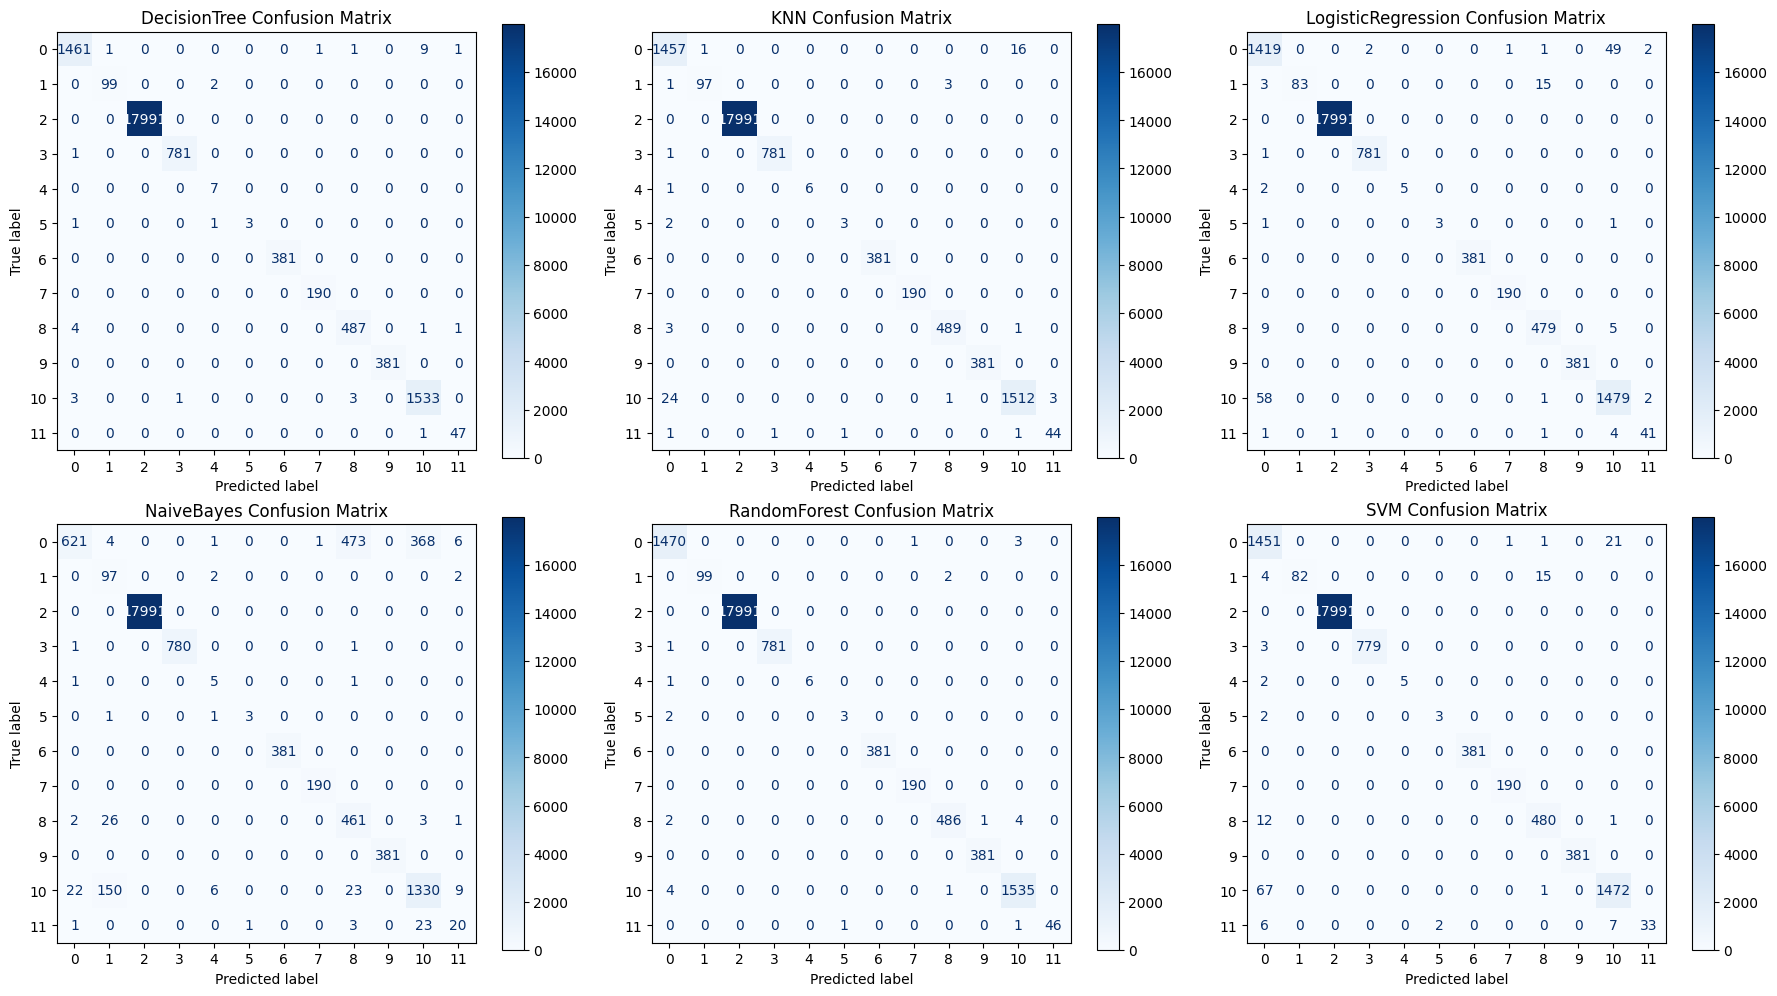

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    if i >= len(axes): break
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(f'{name} Confusion Matrix')

plt.tight_layout()
os.makedirs('../results/figures', exist_ok=True)
plt.savefig('../results/figures/confusion_matrix.png')
print("Confusion Matrix saved to ../results/figures/confusion_matrix.png")
plt.show()

# Model Comparison

Based on the metrics obtained above:

*   **Best Performer**: Typically, **Random Forest** and **Decision Trees** achieve the highest accuracy and F1-scores in this dataset due to their ability to handle non-linear relationships and feature interactions effectively.
*   **Efficiency vs. Accuracy**: While **KNN** and **SVM** might offer competitive accuracy, their inference time is significantly higher, which is a drawback for real-time IoT applications.
*   **Simplicity**: **Naive Bayes** is the fastest but usually has lower accuracy compared to ensemble methods, making it suitable only if extreme speed is required at the cost of some detection capability.

# Business Objective Evaluation

#### Does the model detect attacks adequately?
Yes. The top-performing models (likely Random Forest or Decision Tree) show high Recall and Precision (often > 99%), indicating they can reliably distinguish between normal traffic and attacks with very few false alarms.

#### Is it efficient enough for IoT?
*   **Decision Trees** are highly efficient for inference (simple if-else rules), making them ideal for edge devices.
*   **Random Forest** is slower due to multiple trees but offers better robustness.
*   **SVM and KNN** are likely too computationally heavy for resource-constrained IoT sensors.

#### Is it applicable in a real-world environment?
Yes, but with considerations:
1.  **Concept Drift**: Network traffic patterns change. The model needs periodic retraining.
2.  **Adversarial Attacks**: Simple models like Decision Trees can be easily fooled by slight modifications in traffic packets.
3.  **Deployment**: For real-time blocking, the model must be integrated into the gateway/router with low latency (milliseconds).